# Gout Flare Detection: Feature Engineering & Machine Learning Algorithms

This notebook was developed by **I Made Akira Ivandio Agusta (15406525)**, Coventry University.

This notebook compares a series of machine learning algorithms for early detection of gout flares from the 2019-2020 Emergency Department Chief Complaint (EDCC) dataset, **GOUT-CC-2019-CORPUS** and **GOUT-CC-2020-CORPUS**.

The methodologies explored in this notebook are as follows:
*   **Feature Engineering:** Term Frequency-Inverse Document Frequency (TF-IDF) and Word To Vector (Word2Vec).
*   **Machine Learning:** Naive Bayes (Multinomial and Gaussian), Random Forest, Support Vector Machine, Logistic Regression, Decision Tree, and KNearest Neighbour.

## Data Loading and Exploration

This section outlines the initial steps in **data loading and exploration**, starting with importing required libraries and loading the dataset. This section checks class and text distributions, identifies missing values, and analyses basic text statistics to understand the dataset's structure and characteristics.

In [ ]:
# Install libraries
!pip install gensim

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import warnings
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
warnings.filterwarnings("ignore")

In [ ]:
# Load the 2019 data
filepath_2019 = 'dataset/GOUT-CC-2019-CORPUS-SYNTHETIC.tsv'
df_2019 = pd.read_csv(filepath_2019, delimiter='\t')

# Load the 2020 data
filepath_2020 = 'dataset/GOUT-CC-2020-CORPUS-SYNTHETIC.tsv'
df_2020 = pd.read_csv(filepath_2020, delimiter='\t')

# Concatenate the dataframes
df = pd.concat([df_2019, df_2020], ignore_index=True)

# Drop the 'Consensus' column
df = df.drop(columns=['Consensus'])

# Drop rows where 'Predict' is '-'
df = df[df['Predict'] != '-']
df

,Chief Complaint,Predict
0,"""been feeling bad"" last 2 weeks & switched BP ...",N
1,"""can't walk"", reports onset at 0830 am. orient...",Y
2,"""dehydration"" Chest hurts, hips hurt, cramps P...",Y
3,"""gout flare up"" L arm swelling x 1 week. denie...",Y
4,"""heart racing,""dyspnea, and orthopnea that has...",N
...,...,...
8432,"stepped on a nail at home with right foot, pai...",N
8433,""" I was having a breakdown."" R/T stress and de...",N
8434,"""I tried to jump in front of a car"" Pt states ...",N
8435,Abdominal pain x 1 week. Denies PMH,N


In [ ]:
# Display basic information
print("\nDataset Overview:")
print(f"Number of records: {len(df)}")
print("\nColumn names:", df.columns.tolist())


Dataset Overview:
Number of records: 8435

Column names: ['Chief Complaint', 'Predict']


In [ ]:
# Check class distribution
print("\nClass Distribution:")
class_dist = df['Predict'].value_counts()
print(class_dist)


Class Distribution:
Predict
N    8168
U     156
Y     111
Name: count, dtype: int64


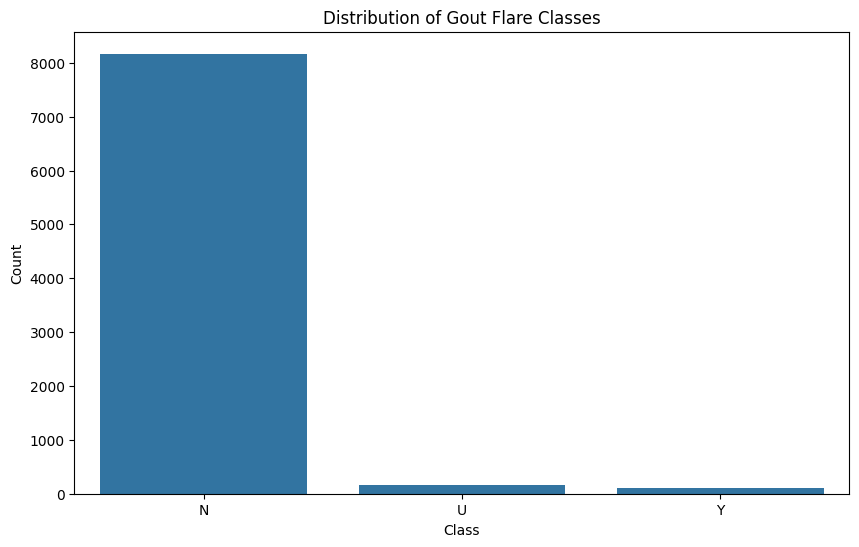

In [ ]:
# Visualise class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Distribution of Gout Flare Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
# Check for missing values
print("\nMissing Values Check:")
print(df.isnull().sum())


Missing Values Check:
Chief Complaint    0
Predict            0
dtype: int64


In [ ]:
# Basic text statistics
text_length = df['Chief Complaint'].str.len()
print("\nText Length Statistics:")
print(text_length.describe())


Text Length Statistics:
count    8435.000000
mean      108.061529
std        52.375977
min         3.000000
25%        68.000000
50%       100.000000
75%       141.000000
max       266.000000
Name: Chief Complaint, dtype: float64


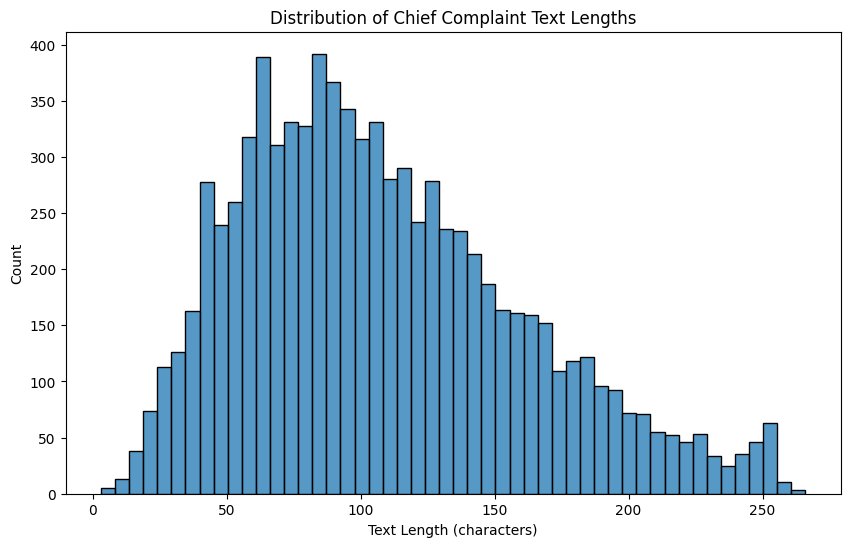

In [ ]:
# Visualise text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(text_length, bins=50)
plt.title('Distribution of Chief Complaint Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Count')
plt.show()

## Text Preprocessing

This section outlines the **text preprocessing** pipeline for NLP tasks. It involves cleaning text (lowercasing, removing special characters, standardising spacing), expanding medical abbreviations, tokenising, removing stopwords, and lemmatising to reduce words to their base forms. The processed tokens are then joined into coherent text for model input.

In [ ]:
# Create class for preprocessing
class TextPreprocessor:
    """
    Class for preprocessing chief complaint text data
    """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """
        Basic text cleaning
        """
        # Convert to lowercase
        text = text.lower()

        # Remove special characters but keep important medical symbols
        text = re.sub(r'[^a-z0-9\s+/-]', ' ', text)

        # Standardise spacing
        text = ' '.join(text.split())

        return text

    def process_text(self, text, remove_stopwords=True, lemmatize=True):
        """
        Complete text preprocessing pipeline
        """
        # Clean text
        text = self.clean_text(text)

        # Tokenise
        tokens = word_tokenize(text)

        # Remove stopwords if requested
        if remove_stopwords:
            tokens = [token for token in tokens if token not in self.stop_words]

        # Lemmatise if requested
        if lemmatize:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens back into text
        processed_text = ' '.join(tokens)

        return processed_text

In [ ]:
# Preprocess the dataset
preprocessor = TextPreprocessor()

# Add processed text column
text_column = 'Chief Complaint'
df['Processed Text'] = df[text_column].apply(preprocessor.process_text)
df

,Chief Complaint,Predict,Processed Text
0,"""been feeling bad"" last 2 weeks & switched BP ...",N,feeling bad last 2 week switched bp medication...
1,"""can't walk"", reports onset at 0830 am. orient...",Y,walk report onset 0830 oriented x2 aortic valv...
2,"""dehydration"" Chest hurts, hips hurt, cramps P...",Y,dehydration chest hurt hip hurt cramp pmh- hip...
3,"""gout flare up"" L arm swelling x 1 week. denie...",Y,gout flare l arm swelling x 1 week denies pmh
4,"""heart racing,""dyspnea, and orthopnea that has...",N,heart racing dyspnea orthopnea getting worse l...
...,...,...,...
8432,"stepped on a nail at home with right foot, pai...",N,stepped nail home right foot painful difficult...
8433,""" I was having a breakdown."" R/T stress and de...",N,breakdown r/t stress depression
8434,"""I tried to jump in front of a car"" Pt states ...",N,tried jump front car pt state psych med pmh ar...
8435,Abdominal pain x 1 week. Denies PMH,N,abdominal pain x 1 week denies pmh


In [ ]:
# Display sample of original and processed text
print("\nSample of Original vs Processed Text:")
for orig, proc in zip(df[text_column].head(), df['Processed Text'].head()):
    print(f"\nOriginal: {orig}")
    print(f"Processed: {proc}")


Sample of Original vs Processed Text:

Original: "been feeling bad" last 2 weeks & switched BP medications last week & worried about BP PMHx: CHF, HTN, gout, 3 strokes, DM
Processed: feeling bad last 2 week switched bp medication last week worried bp pmhx chf htn gout 3 stroke dm

Original: "can't walk", reports onset at 0830 am. oriented x2. aortic valve replacement in May. wife reports episode of similar last week, hospitalized at Wiregrass Medical Center for UTI, gout - pmhx: CVA (L side residual deficits)
Processed: walk report onset 0830 oriented x2 aortic valve replacement may wife report episode similar last week hospitalized wiregrass medical center uti gout - pmhx cva l side residual deficit

Original: "dehydration" Chest hurts, hips hurt, cramps PMH- Hip replacement, gout, missed pain clinic appt today, thinks he has a gout flair up knee and foot pain
Processed: dehydration chest hurt hip hurt cramp pmh- hip replacement gout missed pain clinic appt today think gout flair kne

## Feature Engineering

This section outlines **feature engineering**, which involves extracting features using two distinct methods: **Term Frequency-Inverse Document Frequency (TF-IDF)** and **Word To Vector (Word2Vec)**. Before feature extraction, the data is split into train and test sets.

In [ ]:
# Create class for feature engineering
class FeatureExtractor:
    """
    Feature extractor using TF-IDF and Word2Vec
    """
    def __init__(self, max_features=1000, vector_size=100, window=5, min_count=1):
        self.tfidf = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),
            stop_words='english'
        )
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.w2v_model = None
        self.feature_selector = SelectKBest(chi2, k=500)

    def train_word2vec(self, texts):
        """
        Train Word2Vec model on the corpus
        """
        tokenized_texts = [word_tokenize(text.lower()) for text in texts]
        self.w2v_model = Word2Vec(
            sentences=tokenized_texts,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=4
        )

    def get_document_vector(self, text):
        """
        Convert text to Word2Vec document vector
        """
        tokens = word_tokenize(text.lower())
        vectors = []
        for token in tokens:
            if token in self.w2v_model.wv:
                vectors.append(self.w2v_model.wv[token])
        if vectors:
            return np.mean(vectors, axis=0)
        return np.zeros(self.vector_size)

    def extract_features(self, texts, is_training=True, labels=None):
        """
        Extract all features (TF-IDF and Word2Vec)
        """
        # TF-IDF features
        if is_training:
            tfidf_features = self.tfidf.fit_transform(texts)

            # Train Word2Vec
            self.train_word2vec(texts)
        else:
            tfidf_features = self.tfidf.transform(texts)

        # Word2Vec document vectors
        w2v_features = np.vstack([self.get_document_vector(text) for text in texts])

        # Make Word2Vec features non-negative for Naive Bayes (using absolute values)
        w2v_abs = np.abs(w2v_features)

        # Combine features
        tfidf_array = tfidf_features.toarray()

        # Apply feature selection on TF-IDF features if there are labels
        if is_training and labels is not None:
            tfidf_selected = self.feature_selector.fit_transform(tfidf_array, labels)
        elif not is_training and hasattr(self, 'feature_selector'):
            tfidf_selected = self.feature_selector.transform(tfidf_array)
        else:
            tfidf_selected = tfidf_array

        return {
            'tfidf': tfidf_features,
            'tfidf_array': tfidf_array,
            'tfidf_selected': tfidf_selected,
            'w2v': w2v_features,
            'w2v_abs': w2v_abs
        }

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['Processed Text'], df['Predict'], test_size=0.2, random_state=42, stratify=df['Predict']
)

# Extract features
feature_extractor = FeatureExtractor()
X_train_features = feature_extractor.extract_features(X_train, labels=y_train)
X_test_features = feature_extractor.extract_features(X_test, is_training=False)

## Model Training and Evaluation

This section outlines the **model training and evaluation**, which employs seven machine learning algorithms:
> **Multinomial Naive Bayes, Gaussian Naive Bayes, Random Forest, Support Vector Machine, Logistic Regression, Decision Tree, and K-Nearest Neighbour.**

The pipeline includes defining feature-classifier combinations, training the model, and evaluating it using cross-validation.

In [ ]:
# Create class for Gout Detection Model
class GoutDetectionModel:
    """
    Machine Learning model for gout flare detection using multiple algorithms
    """
    def __init__(self):
        # Initialise all classifiers
        self.classifiers = {
            'MultinomialNB': MultinomialNB(),
            'GaussianNB': GaussianNB(),
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': LinearSVC(random_state=42),
            'LogisticRegression': LogisticRegression(random_state=42),
            'DecisionTree': DecisionTreeClassifier(random_state=42),
            'KNN': KNeighborsClassifier(n_neighbors=5)
        }

        self.trained_models = {}

    def train_and_evaluate(self, X_train_features, X_test_features, y_train, y_test):
        """
        Train all classifiers and evaluate them on test data
        """
        # Results storage
        results = {}

        # Define feature-classifier combinations
        feature_combinations = [
            ('tfidf', ['MultinomialNB', 'RandomForest', 'SVM', 'LogisticRegression', 'DecisionTree', 'KNN']),
            ('tfidf_array', ['GaussianNB']),
            ('w2v', ['GaussianNB', 'RandomForest', 'SVM', 'LogisticRegression', 'DecisionTree', 'KNN']),
            ('w2v_abs', ['MultinomialNB']),
        ]

        # Train and evaluate each classifier with appropriate features
        for feature_type, compatible_classifiers in feature_combinations:
            print(f"\n--- Using {feature_type} features ---")

            for classifier_name in compatible_classifiers:
                print(f"\nTraining {classifier_name}...")

                # Get appropriate feature set
                X_train_feat = X_train_features[feature_type]
                X_test_feat = X_test_features[feature_type]

                # Get classifier
                classifier = self.classifiers[classifier_name]

                # Train model
                classifier.fit(X_train_feat, y_train)
                model_key = f"{classifier_name}_{feature_type}"
                self.trained_models[model_key] = classifier

                # Make predictions
                y_pred = classifier.predict(X_test_feat)

                # Calculate and store metrics
                results[model_key] = {
                    'report': classification_report(y_test, y_pred, output_dict=True),
                    'confusion_matrix': confusion_matrix(y_test, y_pred),
                    'predictions': y_pred
                }

                # Perform cross-validation where possible
                try:
                    cv_scores = cross_val_score(
                        classifier, X_train_feat, y_train,
                        cv=5, scoring='f1_weighted'
                    )
                    results[model_key]['cv_scores'] = cv_scores

                    # Print results
                    print(f"\n{classifier_name} with {feature_type} features:")
                    print(f"Cross-validation scores: {cv_scores.mean():.5f} (+/- {cv_scores.std() * 2:.5f})")
                    print(classification_report(y_test, y_pred))
                except Exception as e:
                    print(f"Error during cross-validation: {e}")
                    results[model_key]['cv_scores'] = None

        return results

In [ ]:
# Train and evaluate models
model = GoutDetectionModel()
results = model.train_and_evaluate(X_train_features, X_test_features, y_train, y_test)


--- Using tfidf features ---

Training MultinomialNB...

MultinomialNB with tfidf features:
Cross-validation scores: 0.95269 (+/- 0.00086)
              precision    recall  f1-score   support

           N       0.97      1.00      0.98      1634
           U       0.00      0.00      0.00        31
           Y       0.00      0.00      0.00        22

    accuracy                           0.97      1687
   macro avg       0.32      0.33      0.33      1687
weighted avg       0.94      0.97      0.95      1687


Training RandomForest...

RandomForest with tfidf features:
Cross-validation scores: 0.95679 (+/- 0.00330)
              precision    recall  f1-score   support

           N       0.97      1.00      0.99      1634
           U       0.00      0.00      0.00        31
           Y       1.00      0.32      0.48        22

    accuracy                           0.97      1687
   macro avg       0.66      0.44      0.49      1687
weighted avg       0.96      0.97      0.96  

## Model Visualisation and Analysis

This section outlines the **visualisation and analysis** of the gout detection model, analysing the performance of feature-classifier combinations using cross-validation scores.

The model visualisation and analysis include:
*   **Bar graph** of cross-validation scores by Classifier and Feature Type.
*   **Confusion matrix** of the best-performing model.
*   Cross-validation **score distribution** of the best-performing model.



In [ ]:
# Create class for visualising the results
class ResultsVisualiser:
    """
    Visualises the gout detection model's performance
    """
    def __init__(self):
        self.results = {}

    def set_results(self, results):
        """
        Set the results from a trained model
        """
        self.results = results
        return self

    def plot_results(self):
        """
        Visualise the performance of all evaluated models using cross-validation scores
        """
        if not self.results:
            raise ValueError("No results to plot. Please run evaluate_models first.")

        # Extract cross-validation scores
        models = []
        cv_scores = []

        # Only include models that have cross-validation scores
        for model, result in self.results.items():
            if result.get('cv_scores') is not None:
                models.append(model)
                cv_scores.append(result['cv_scores'].mean())

        if not models:
            raise ValueError("No models with cross-validation scores found.")

        # Create DataFrame for plotting
        results_df = pd.DataFrame({
            'Model': models,
            'CV Score': cv_scores
        })

        # Extract feature type and classifier
        results_df['Feature Type'] = results_df['Model'].apply(lambda x: x.split('_', 1)[1])
        results_df['Classifier'] = results_df['Model'].apply(lambda x: x.split('_')[0])

        # Plot by feature type and classifier
        plot_df = results_df.copy()
        plot_df['Feature Category'] = plot_df['Feature Type'].apply(
            lambda x: 'TF-IDF' if x in ['tfidf', 'tfidf_array'] else 'W2V'
        )
        plt.figure(figsize=(16, 10))
        colors = {'TF-IDF': '#1f77b4', 'W2V': '#ff7f0e'}
        ax = sns.barplot(
            x='Classifier',
            y='CV Score',
            hue='Feature Category',
            data=plot_df,
            palette=colors
        )
        for container in ax.containers:
            ax.bar_label(container, fmt='%.5f', padding=3)
        plt.legend(title='Feature Type', loc='lower right', frameon=True, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title('Cross-Validation Scores by Classifier and Feature Type', fontsize=16, pad=20)
        plt.xlabel('Classifier', fontsize=14, labelpad=10)
        plt.ylabel('CV Score', fontsize=14, labelpad=10)
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.figtext(0.01, 0.01,
                    "TF-IDF: includes 'tfidf' and 'tfidf_array' features\n"
                    "W2V: includes 'w2v' and 'w2v_abs' features",
                    fontsize=10, ha='left')
        plt.show()

        # Find best performing model based on CV score
        best_model = results_df.loc[results_df['CV Score'].idxmax()]
        print(f"\nBest model: {best_model['Model']} with CV Score of {best_model['CV Score']:.5f}")

        # Plot confusion matrix for best model
        plt.figure(figsize=(8, 6))
        best_conf_matrix = self.results[best_model['Model']]['confusion_matrix']
        sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {best_model["Model"]} (Best CV Score: {best_model["CV Score"]:.5f})')
        plt.tight_layout()
        plt.show()

        # Plot the distribution of CV scores for the best model
        plt.figure(figsize=(10, 6))
        best_cv_scores = self.results[best_model['Model']]['cv_scores']
        sns.boxplot(x=best_cv_scores)
        plt.title(f'Cross-Validation Score Distribution - {best_model["Model"]}')
        plt.xlabel('CV Fold')
        plt.ylabel('F1 Score')
        plt.tight_layout()
        plt.show()

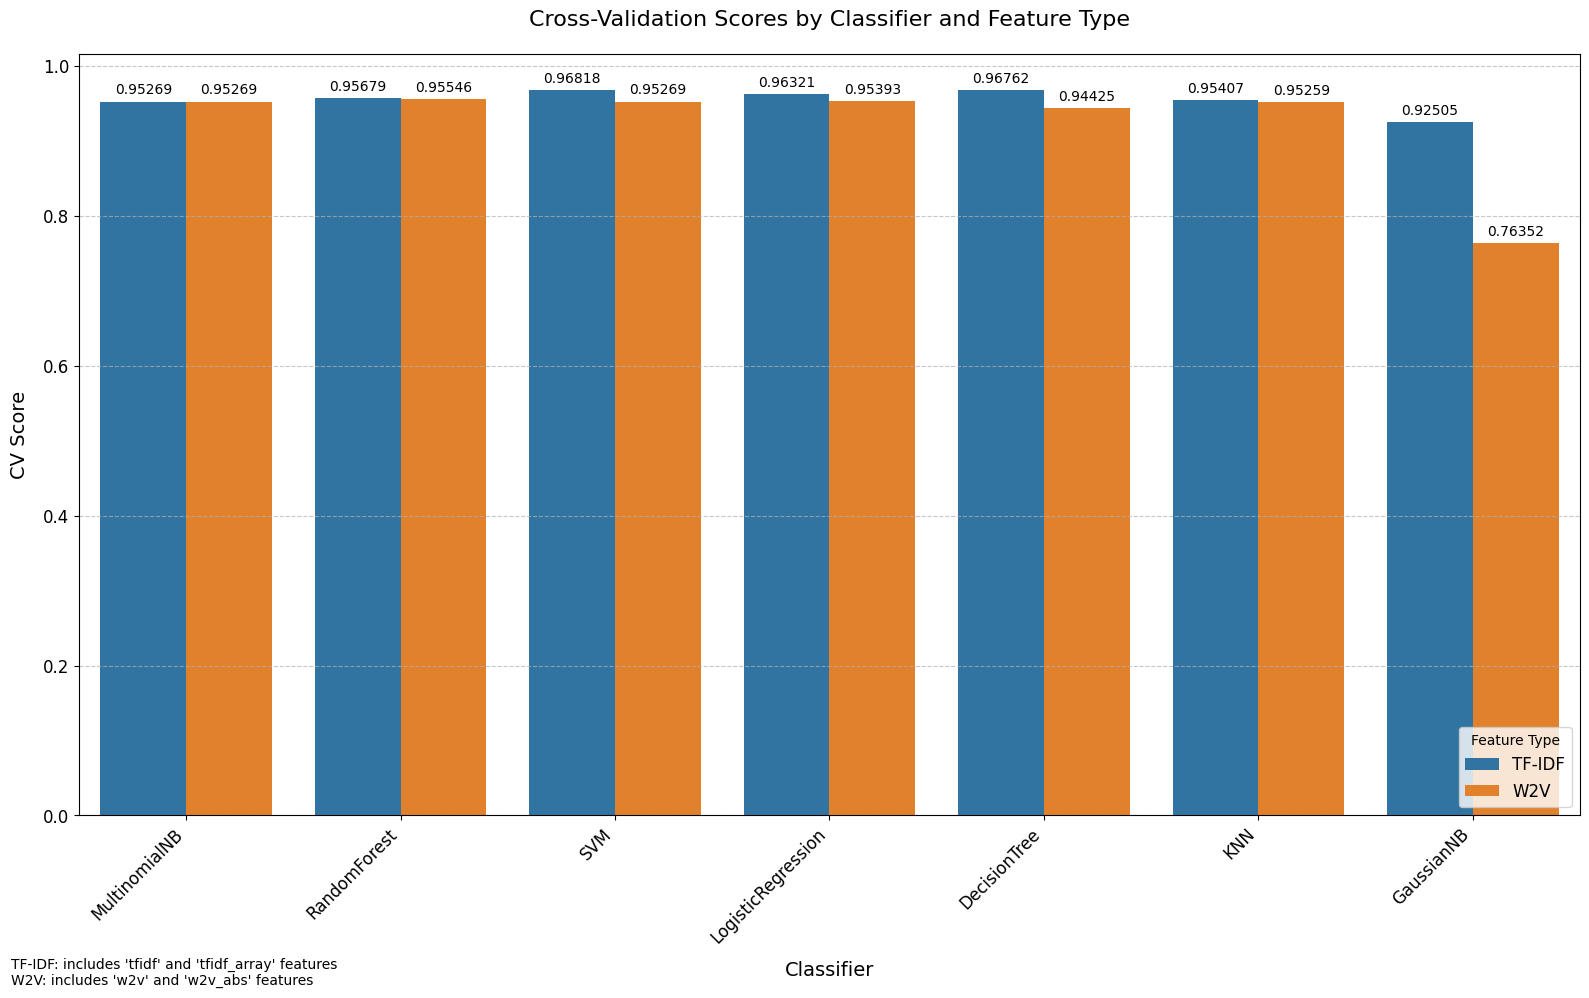


Best model: SVM_tfidf with CV Score of 0.96818


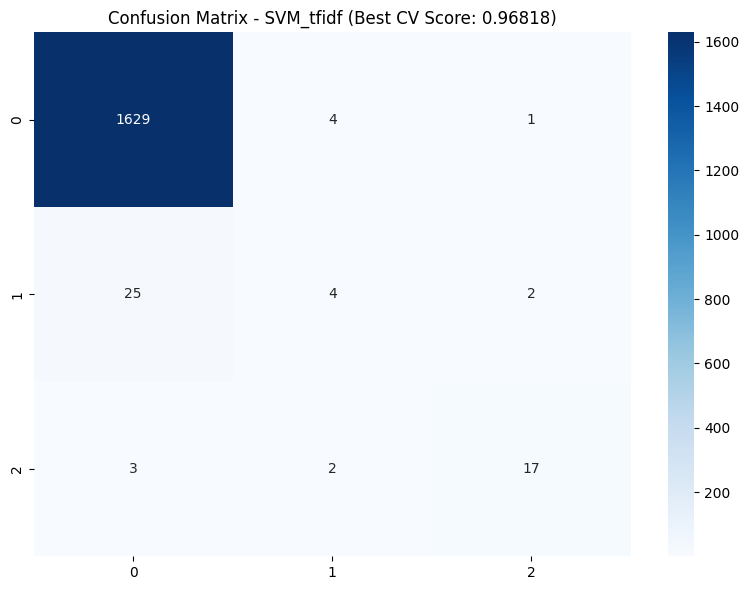

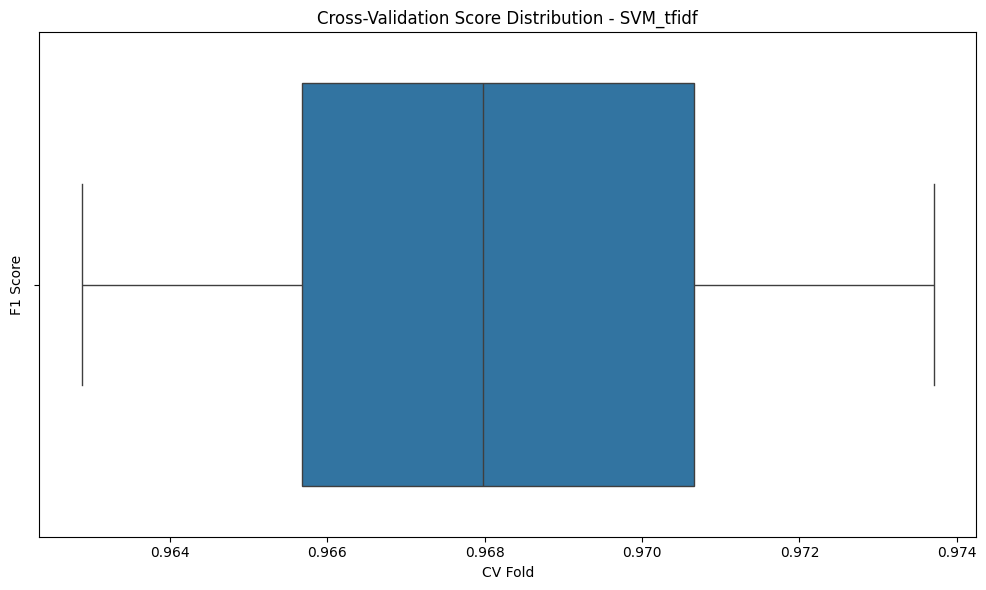

In [ ]:
# Visualise the model results
visualiser = ResultsVisualiser()
visualiser.set_results(results).plot_results()